# Momentary tinnitus with a user split approach
How do the machine learning classification results vary, if we create a sub_df containing only the users in `(10, 4000]` and split on a *user_level*, i.e. one user id goes into training but is excluded from testing and vice versa.


In [1]:
# project location
p_loc = 'C:/Users/joa24jm/Documents/tinnitus-country/'

In [2]:
# !pip install imblearn

In [3]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utilities as u
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import joblib
from sklearn.metrics import confusion_matrix
import datetime
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GroupKFold
import seaborn as sns
from sklearn.metrics import accuracy_score

In [4]:
# read in dfs
df = pd.read_csv(p_loc + 'data/03_processed/df_equal_splits_with_age_with_question2_question_3.csv')

In [5]:
#%% select features and target
features = ['AT', 'CA', 'CH','DE','GB', 'IT', 'NL', 'NO', 'RU', 'US', # countries
            'autumn', 'spring', 'summer', 'winter',                  # season
            'Male', 'age',                                 # demographics
            'question4', 'question5', 'question6', 'question7',
            'user_id']      # EMAs

X = df[features] # all columns except for the last
y = df['question1']  # Did you perceive the tinnitus right now? -> Classification problem

In [6]:
# map filled_out_bins to column 'user_id' to create a groupby object
dic = dict(zip(df.user_id.value_counts().index, df.user_id.value_counts().values))
df['filled_out_questionnaires'] = df['user_id'].map(dic)

Ignore the warning, operation works as intended

In [7]:
# keep only users that have more than 10 filled out questionnaires
#df = df[(df.filled_out_questionnaires > 100) & (df.filled_out_questionnaires <= 1000)]

In [8]:
# create groups of user ids for a grouped kfold crossvalidation
groups = np.array(df['user_id'].tolist())
group_kfold = GroupKFold(n_splits=5)

In [9]:
# split users randomly into train and test users
user_ids = df.user_id.unique()
test_size = 0.2
# random.seed(42)
train_users = random.sample(set(user_ids), k=int(len(user_ids)*(1-test_size)))
test_users = list(set(user_ids) - set(train_users))

In [10]:
# check if train_users and test_users are distinct
len(user_ids) == len(set(train_users) | set(test_users))

True

In [11]:
cnt = 0
for train_idxs, test_idxs in group_kfold.split(X, y, groups):
    
    # print to console which at fold we are
    cnt = cnt + 1
    print('Fold ', cnt)    
    
    # create train and test df
    df_train = df.loc[train_idxs, :]
    df_test = df.loc[test_idxs, :]
    
    #%% draw randomly from the stratum with question1 == 0 and add these to the df
    # so that question1 becomes equally distributed

    # train users
    times_to_draw = abs(df_train.question1.value_counts()[1] - df_train.question1.value_counts()[0])
    minority_class = df_train.question1.value_counts().idxmin()
    sampled_df = df_train[df_train.question1 == minority_class].sample(n=times_to_draw, replace = True)
    df_train = df_train.append(sampled_df, ignore_index = True)

    # test users
    times_to_draw = abs(df_test.question1.value_counts()[1] - df_test.question1.value_counts()[0])
    minority_class = df_test.question1.value_counts().idxmin()
    sampled_df = df_test[df_test.question1 == minority_class].sample(n=times_to_draw, replace = True)
    df_test = df_test.append(sampled_df, ignore_index = True)
    
    # shuffle data before training
    df_test = df_test.sample(frac=1).reset_index(drop=True)
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    
    # create x and y
    x_train = df_train[features] # all columns except for the last
    y_train = df_train['question1']  # Did you perceive the tinnitus right now? -> Classification problem

    x_test = df_test[features]
    y_test = df_test['question1']
    
    # safe date of approach
    tday = datetime.datetime.now().strftime('%y_%m_%d_%H_%M')

    clfs = [GradientBoostingClassifier()]

    # use the optimum parameters from the grid_search as reported in the country paper
    params_gb = {'learning_rate': [0.5], # helps for inbalanced classes as we have, maybe something like a learning rate?
                'max_depth': [10],
                'verbose': [0],
                'random_state' : [42],
                'subsample': [1],
                'min_samples_leaf': [1],
                'max_features': [.5]
                } 

    # safe params into a list of params to loop over
    param_grids = [params_gb]

    # set up scores
    scores = {'gb': None}

    # save trained clfs
    trained_clfs= []
    
    for param_grid, clf, key in zip(param_grids, clfs, scores.keys()):
        gridsearch = GridSearchCV(estimator = clf, 
                                  param_grid = param_grid,
                                  scoring = 'accuracy',
                                  n_jobs = -1,
                                  cv = 3,
                                  refit = True,
                                  verbose = 2)

        # perform gridsearch on train data
        gridsearch.fit(x_train, y_train)

        # refit best estimator
        gridsearch.best_estimator_.fit(x_train, y_train)
        
        # predict on test set
        y_pred = gridsearch.best_estimator_.predict(x_test)
        
        # calculate accuracy
        print('Accuracy:\t', accuracy_score(y_test, y_pred))
        
        # calculate confusion matrix
        print('Confusion Matrix')
        labels = ['Tinnitus NO', 'Tinnitus YES']
        print(pd.DataFrame(confusion_matrix(y_test, y_pred), index = labels, 
                     columns = labels))
        
        print('##################################')
        
        

Fold  1
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Accuracy:	 0.5194830396646744
Confusion Matrix
              Tinnitus NO  Tinnitus YES
Tinnitus NO          2486         10397
Tinnitus YES         1984         10899
##################################
Fold  2
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Accuracy:	 0.5556485689229053
Confusion Matrix
              Tinnitus NO  Tinnitus YES
Tinnitus NO          2792          9751
Tinnitus YES         1396         11147
##################################
Fold  3
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Accuracy:	 0.5972545369939507
Confusion Matrix
              Tinnitus NO  Tinnitus YES
Tinnitus NO          4125          8769
Tinnitus YES         1617         11277
##################################
Fold  4
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Accuracy:	 0.5074859113466229
Confusion Matrix
              Tinnitus NO  Tinnitus YES
Tinnitus NO          2850          9039

### Poor accuracy between 48 and 58 % if we split on a user level, even for a grouped 5 fold validation

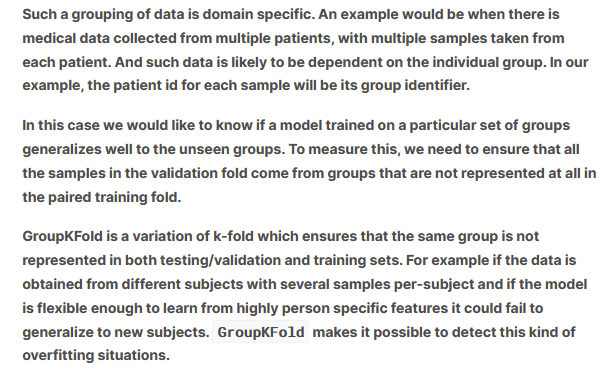

https://www.kaggle.com/reighns/groupkfold-and-stratified-groupkfold-efficientnet